In [ ]:
# =========================
# Multimodal deepfake project: Pair-aware split + VGG16 -> BiLSTM training pipeline
# =========================

# Cell 1: imports and seeds
import os
import random
import math
import shutil
from pathlib import Path
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
import cv2
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import json
import time
import warnings
warnings.filterwarnings("ignore")

# reproducibility seeds
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Paths (adjust if needed)
REAL_ROOT = "/kaggle/input/dataset/Extracted_Faces/Extracted_Faces/real"
DEEPFAKE_ROOT = "/kaggle/input/dataset/Extracted_Faces/Extracted_Faces/deepfake"
OUT_DIR = "/kaggle/working"
CSV_DIR = os.path.join(OUT_DIR, "csvs")
os.makedirs(CSV_DIR, exist_ok=True)

# Hyperparams (change as needed)
SEQ_LEN = 16            # frames per video clip (T)
IMG_SIZE = 224
BATCH_SIZE = 8          # adjust depending on GPU RAM
EPOCHS = 30
INITIAL_LR = 1e-4
FINE_TUNE_LR = 1e-5
TRAIN_BACKBONE = True   # whether to unfreeze top VGG block for fine-tuning (we'll do phased training)
PATIENCE_ES = 8

print("TensorFlow version:", tf.__version__)
print("NUM GPUs available:", len(tf.config.list_physical_devices('GPU')))

2025-09-29 17:53:33.579922: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759168413.970228      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759168414.077256      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
NUM GPUs available: 2


In [ ]:
# -------------------------
# Cell 2: Helper utilities
# -------------------------
def norm_foldername(name):
    """
    Normalize folder name: if folder is '000' or '000.mp4', return '000' for matching.
    But we will preserve original folder names when writing CSVs.
    """
    name_str = str(name)
    if name_str.endswith(".mp4"):
        return name_str[:-4]
    return name_str

def list_video_folders(root):
    """Return list of folder names (not full paths) inside root that are directories and appear to hold frames."""
    items = sorted([p for p in os.listdir(root) if os.path.isdir(os.path.join(root, p))])
    return items

def parse_pair_from_deepfake_name(foldername):
    """
    Given deepfake folder like 'A_B.mp4' or 'A_B', return tuple (A, B) normalized (without .mp4).
    """
    base = foldername
    if base.endswith(".mp4"):
        base = base[:-4]
    if "_" not in base:
        return None
    a, b = base.split("_", 1)
    return (a, b)

In [ ]:
# -------------------------
# Cell 3: Build pair list and splits
# -------------------------
real_folders = list_video_folders(REAL_ROOT)
deep_folders = list_video_folders(DEEPFAKE_ROOT)

print(f"Found {len(real_folders)} real folders and {len(deep_folders)} deepfake folders.")

# Map normalized real ids -> folder name (support both '000' or '000.mp4' naming)
real_norm_to_folder = {norm_foldername(f): f for f in real_folders}

# Build pairs from deepfakes by parsing names
pairs_set = set()
missing_real = set()
for df in deep_folders:
    parsed = parse_pair_from_deepfake_name(df)
    if parsed is None:
        continue
    a, b = parsed
    # both a and b should exist among reals (best-effort)
    if a not in real_norm_to_folder or b not in real_norm_to_folder:
        # record missing - still include pair if reals missing? we'll flag error.
        missing_real.add((df, parsed))
    # unordered pair (set)
    pair_key = tuple(sorted([a, b]))
    pairs_set.add(pair_key)

pairs = sorted(list(pairs_set))
num_pairs = len(pairs)
print(f"Derived {num_pairs} unique pairs from deepfake folder names.")

if num_pairs == 0:
    raise RuntimeError("No pairs found. Check folder naming conventions (deepfake folders should be 'A_B' or 'A_B.mp4').")

# expected counts (if you have 500 pairs)
print("Example pairs (first 10):", pairs[:10])
if missing_real:
    print("Warning: some deepfake names reference real names not found in real folders (logged). Examples:", list(missing_real)[:5])

# Create split indices
n_train_pairs = int(math.floor(0.70 * num_pairs))
n_val_pairs = int(math.floor(0.15 * num_pairs))
n_test_pairs = num_pairs - n_train_pairs - n_val_pairs  # ensure sum matches

print(f"Pairs -> train: {n_train_pairs}, val: {n_val_pairs}, test: {n_test_pairs}")

# shuffle pairs reproducibly
random.Random(RANDOM_SEED).shuffle(pairs)

train_pairs = pairs[:n_train_pairs]
val_pairs = pairs[n_train_pairs:n_train_pairs + n_val_pairs]
test_pairs = pairs[n_train_pairs + n_val_pairs:]

# Build lists of video folder names per split (include reals and both deepfakes)
def expand_pair_to_videos(pair):
    a, b = pair  # these are normalized without .mp4
    # real folder names
    real_a = real_norm_to_folder.get(a)
    real_b = real_norm_to_folder.get(b)
    # deepfake folder names expected to be like 'a_b.mp4' or 'a_b'
    df_ab = f"{a}_{b}.mp4" if f"{a}_{b}.mp4" in deep_folders else f"{a}_{b}"
    df_ba = f"{b}_{a}.mp4" if f"{b}_{a}.mp4" in deep_folders else f"{b}_{a}"
    videos = []
    if real_a:
        videos.append((real_a, "real"))
    if real_b:
        videos.append((real_b, "real"))
    # include deepfakes if present
    if f"{a}_{b}.mp4" in deep_folders or f"{a}_{b}" in deep_folders:
        # prefer folder name as-is
        ab_name = f"{a}_{b}.mp4" if f"{a}_{b}.mp4" in deep_folders else f"{a}_{b}"
        videos.append((ab_name, "deepfake"))
    if f"{b}_{a}.mp4" in deep_folders or f"{b}_{a}" in deep_folders:
        ba_name = f"{b}_{a}.mp4" if f"{b}_{a}.mp4" in deep_folders else f"{b}_{a}"
        videos.append((ba_name, "deepfake"))
    return videos

def build_split_rows(pair_list, split_name):
    rows = []
    for pair in pair_list:
        videos = expand_pair_to_videos(pair)
        if not videos:
            # log and continue
            print("Warning: pair", pair, "expanded to no video folders (missing).")
        for foldername, label in videos:
            # full path depending on label
            root = REAL_ROOT if label == "real" else DEEPFAKE_ROOT
            folder_path = os.path.join(root, foldername)
            if not os.path.isdir(folder_path):
                # log and skip
                print(f"Missing folder on disk: {folder_path} (skipping).")
                continue
            rows.append({"video_id": foldername, "label": label, "frame_folder": folder_path, "split": split_name})
    return rows

train_rows = build_split_rows(train_pairs, "train")
val_rows = build_split_rows(val_pairs, "val")
test_rows = build_split_rows(test_pairs, "test")

print(f"Final counts -> train videos: {len(train_rows)}, val videos: {len(val_rows)}, test videos: {len(test_rows)}")

# Save CSVs
train_df = pd.DataFrame(train_rows)
val_df = pd.DataFrame(val_rows)
test_df = pd.DataFrame(test_rows)
for name, df in [("train", train_df), ("val", val_df), ("test", test_df)]:
    csv_path = os.path.join(CSV_DIR, f"{name}.csv")
    df.to_csv(csv_path, index=False)
    print("Wrote", csv_path, "rows:", len(df))

# Integrity checks: ensure no video folder appears in multiple splits
all_vids = pd.concat([train_df[['video_id','split']], val_df[['video_id','split']], test_df[['video_id','split']]])
dup = all_vids[all_vids.duplicated('video_id', keep=False)].sort_values('video_id')
if not dup.empty:
    print("ERROR: Some video folders appear in more than one split! List:")
    print(dup.head(50))
    raise RuntimeError("Split integrity check failed: duplicates across splits.")
else:
    print("Split integrity check passed: no duplicate video folders across splits.")

Found 1000 real folders and 1000 deepfake folders.
Derived 500 unique pairs from deepfake folder names.
Example pairs (first 10): [('000', '003'), ('001', '870'), ('002', '006'), ('004', '982'), ('005', '010'), ('007', '132'), ('008', '990'), ('009', '027'), ('011', '805'), ('012', '026')]
Pairs -> train: 350, val: 75, test: 75
Final counts -> train videos: 1400, val videos: 300, test videos: 300
Wrote /kaggle/working/csvs/train.csv rows: 1400
Wrote /kaggle/working/csvs/val.csv rows: 300
Wrote /kaggle/working/csvs/test.csv rows: 300
Split integrity check passed: no duplicate video folders across splits.


In [ ]:
# -------------------------
# Cell 4: tf.data pipeline utilities
# -------------------------
# Image loader using cv2 (fast). Use tf.py_function wrapper in mapping.
def load_image_cv2(path, img_size=IMG_SIZE):
    """Load a jpeg image from path (string), return HWC float32 RGB preprocessed for VGG16."""
    # path: bytes input from tf.py_function -> decode to str
    if isinstance(path, bytes):
        path = path.decode('utf-8')
    if not os.path.exists(path):
        # fallback blank
        img = np.zeros((img_size, img_size, 3), dtype=np.float32)
        return img
    img = cv2.imread(path)
    if img is None:
        img = np.zeros((img_size, img_size, 3), dtype=np.uint8)
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_AREA)
    img = img.astype(np.float32)
    img = tf.keras.applications.vgg16.preprocess_input(img)  # subtracts mean, etc.
    return img

def sample_frames_from_folder_py(frame_folder, t=SEQ_LEN, mode="uniform"):
    """Return numpy array shape (t, H, W, 3) from folder of frames. Handles small N by repeating last frame."""
    if isinstance(frame_folder, bytes):
        frame_folder = frame_folder.decode('utf-8')
    paths = sorted([os.path.join(frame_folder, f) for f in os.listdir(frame_folder) if f.lower().endswith(('.jpg','.jpeg','.png'))])
    N = len(paths)
    if N == 0:
        # return zeros
        return np.zeros((t, IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)
    if N <= t:
        idx = list(range(N)) + [N-1]*(t-N)
    else:
        if mode == "uniform":
            idx = np.linspace(0, N-1, t).astype(int).tolist()
        elif mode == "random":
            start = random.randint(0, max(0, N-t))
            idx = list(range(start, start+t))
        else:
            idx = sorted(random.sample(range(N), t))
    imgs = [load_image_cv2(paths[i], img_size=IMG_SIZE) for i in idx]
    arr = np.stack(imgs, axis=0).astype(np.float32)  # (t, H, W, 3)
    return arr

# Wrapper for tf.data (returns tf.float32 tensor)
def tf_sample_frames(frame_folder, label, mode="uniform"):
    """
    frame_folder: tf.string; label: tf.int32 or float
    returns (seq (t,H,W,3), label)
    """
    # use py_function to call Python sampling function
    seq = tf.py_function(func=lambda p: sample_frames_from_folder_py(p.decode('utf-8'), t=SEQ_LEN, mode=mode),
                         inp=[frame_folder],
                         Tout=tf.float32)
    # set static shape so TF knows
    seq.set_shape([SEQ_LEN, IMG_SIZE, IMG_SIZE, 3])
    return seq, label

# Augmentations (applied on numpy arrays inside a py_function would be slow).
# Instead, we will implement simple augmentations with tf.image on the tensors after sampling:
def augment_sequence_tf(seq):
    # seq: (T,H,W,3) float32 preprocessed for VGG (may contain negative values due to vgg preprocessing)
    # We perform mild augmentations in pixel space — note: vgg preprocessing expects BGR mean-subtracted values,
    # but random flip and slight brightness adjustments are still acceptable.
    # Random horizontal flip
    seq = tf.cond(tf.random.uniform([], 0, 1) > 0.5, lambda: tf.reverse(seq, axis=[2]), lambda: seq)
    # Random brightness/contrast on whole clip
    seq = tf.image.random_brightness(seq, max_delta=0.05)  # small
    seq = tf.image.random_contrast(seq, 0.95, 1.05)
    # Clip - we keep values as float32; don't clip to 0-255 because VGG preprocess expects certain ranges
    return seq

# Dataset builder
def build_dataset_from_df(df, mode="train", batch_size=BATCH_SIZE, shuffle=True):
    """
    df: pandas DataFrame with columns ['frame_folder','label']
    mode: 'train'|'val'|'test'
    """
    frame_folders = df['frame_folder'].astype(str).tolist()
    labels = (df['label'] == 'deepfake').astype(np.float32).tolist()  # deepfake -> 1.0, real -> 0.0

    ds = tf.data.Dataset.from_tensor_slices((frame_folders, labels))
    if shuffle and mode == "train":
        ds = ds.shuffle(buffer_size=len(frame_folders), seed=RANDOM_SEED)

    def map_fn(path, lab):
        seq, lab = tf_sample_frames(path, lab, mode="random" if mode=="train" else "uniform")
        if mode == "train":
            seq = augment_sequence_tf(seq)
        return seq, lab

    ds = ds.map(lambda p, l: tf.numpy_function(lambda pp, ll: (sample_frames_from_folder_py(pp.decode('utf-8'), t=SEQ_LEN, mode="random" if mode=="train" else "uniform"), np.float32(ll)),
                                                inp=[p, l],
                                                Tout=[tf.float32, tf.float32]),
                num_parallel_calls=tf.data.AUTOTUNE)
    # set shapes
    def set_shapes(seq, lab):
        seq.set_shape([SEQ_LEN, IMG_SIZE, IMG_SIZE, 3])
        lab.set_shape([])
        return seq, lab

    ds = ds.map(set_shapes, num_parallel_calls=tf.data.AUTOTUNE)
    if mode == "train":
        ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    else:
        ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

# Quick smoke test: build a small dataset (first few rows) to verify shapes
print("Preparing small smoke test of tf.data (first 2 train rows if available)...")
if len(train_df) > 0:
    try:
        ds_smoke = build_dataset_from_df(train_df.head(2), mode="train", batch_size=1, shuffle=False)
        for x,y in ds_smoke.take(1):
            print("Smoke seq shape:", x.shape, "label shape:", y.shape)
    except Exception as e:
        print("Smoke test failed:", e)
else:
    print("No train rows found; skip smoke test.")

Preparing small smoke test of tf.data (first 2 train rows if available)...


I0000 00:00:1759168436.438472      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1759168436.439271      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Smoke seq shape: (1, 16, 224, 224, 3) label shape: (1,)


In [5]:
# -------------------------
# Cell 5: Build the model (VGG16 -> BiLSTM)
# -------------------------
def build_vgg16_lstm(seq_len=SEQ_LEN, img_shape=(IMG_SIZE, IMG_SIZE, 3), lstm_units=[256, 128], freeze_backbone=True):
    # Input sequence
    inp = layers.Input(shape=(seq_len, *img_shape), name='frames')
    # We'll apply VGG16 with pooling='avg' to produce a vector per frame efficiently.
    # Build single-frame VGG model
    vgg_frame = VGG16(weights='imagenet', include_top=False, pooling='avg', input_shape=img_shape)
    # freeze as requested
    if freeze_backbone:
        for layer in vgg_frame.layers:
            layer.trainable = False

    # TimeDistributed wrapper (applies same vgg to each frame)
    x = layers.TimeDistributed(vgg_frame)(inp)  # shape: (batch, T, feat_dim)
    # optional projection
    x = layers.TimeDistributed(layers.Dense(512, activation='relu'))(x)
    x = layers.TimeDistributed(layers.Dropout(0.25))(x)

    # BiLSTM stack
    x = layers.Bidirectional(layers.LSTM(lstm_units[0], return_sequences=True))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Bidirectional(layers.LSTM(lstm_units[1], return_sequences=False))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    # Dense head
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(1, activation='sigmoid', name='out')(x)

    model = models.Model(inputs=inp, outputs=out)
    return model

# Build model (initially freeze backbone)
model = build_vgg16_lstm(freeze_backbone=True)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR),
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(name='auc')])
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ frames (InputLayer)             │ (None, 16, 224, 224,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 16, 512)        │    14,714,688 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 16, 512)        │       262,656 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 16, 512)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 16, 512)        │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out (Dense)                     │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,244,737 (65.78 MB)

 Trainable params: 2,528,513 (9.65 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

In [6]:
# -------------------------
# Cell 6: Training routine (phase 1 freeze, phase 2 fine-tune optional)
# -------------------------
train_ds = build_dataset_from_df(train_df, mode="train", batch_size=BATCH_SIZE, shuffle=True)
val_ds = build_dataset_from_df(val_df, mode="val", batch_size=BATCH_SIZE, shuffle=False)

# Callbacks
ckpt_path = os.path.join(OUT_DIR, "best_vgg_lstm.h5")
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(ckpt_path, monitor='val_auc', mode='max', save_best_only=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_auc', mode='max', factor=0.5, patience=3, verbose=1, min_lr=1e-7),
    tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=PATIENCE_ES, restore_best_weights=True, verbose=1)
]

steps_per_epoch = max(1, math.ceil(len(train_df) / BATCH_SIZE))
validation_steps = max(1, math.ceil(len(val_df) / BATCH_SIZE))
print("Steps per epoch:", steps_per_epoch, "Validation steps:", validation_steps)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)


Steps per epoch: 175 Validation steps: 38
Epoch 1/30


I0000 00:00:1759168464.208242      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 736ms/step - auc: 0.5026 - loss: 1.1414
Epoch 1: val_auc improved from -inf to 0.72436, saving model to /kaggle/working/best_vgg_lstm.h5
175/175 ━━━━━━━━━━━━━━━━━━━━ 192s 932ms/step - auc: 0.5029 - loss: 1.1408 - val_auc: 0.7244 - val_loss: 0.6222 - learning_rate: 1.0000e-04
Epoch 2/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 769ms/step - auc: 0.5758 - loss: 1.0047
Epoch 2: val_auc improved from 0.72436 to 0.75882, saving model to /kaggle/working/best_vgg_lstm.h5
175/175 ━━━━━━━━━━━━━━━━━━━━ 164s 937ms/step - auc: 0.5758 - loss: 1.0046 - val_auc: 0.7588 - val_loss: 0.5880 - learning_rate: 1.0000e-04
Epoch 3/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 769ms/step - auc: 0.6497 - loss: 0.8602
Epoch 3: val_auc improved from 0.75882 to 0.79896, saving model to /kaggle/working/best_vgg_lstm.h5
175/175 ━━━━━━━━━━━━━━━━━━━━ 164s 936ms/step - auc: 0.6497 - loss: 0.8602 - val_auc: 0.7990 - val_loss: 0.5493 - learning_rate: 1.0000e-04
Epoch 4/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 770ms

In [9]:
# -------------------------
# Cell 7: Evaluation on test set (video-level) + Visualizations
# -------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, accuracy_score, roc_curve, precision_recall_curve, auc

# Build test dataset with deterministic sampling and batch_size=1 to get per-video preds easily
test_ds_single = build_dataset_from_df(test_df, mode="test", batch_size=1, shuffle=False)

y_true = []
y_pred = []
video_ids = []

# Iterate test_df rows and predict each video (one deterministic clip per video).
for idx, row in test_df.iterrows():
    folder = row['frame_folder']
    label = 1 if row['label'] == 'deepfake' else 0
    try:
        seq = sample_frames_from_folder_py(folder, t=SEQ_LEN, mode="uniform")
        seq_batch = np.expand_dims(seq, axis=0)
        pred = model.predict(seq_batch, verbose=0)[0,0]
    except Exception as e:
        print(f"Error processing video {row['video_id']}: {e}")
        pred = 0.5  # fallback prob
    y_true.append(label)
    y_pred.append(pred)
    video_ids.append(row['video_id'])

# Compute metrics
y_pred_bin = [1 if p >= 0.5 else 0 for p in y_pred]
acc = accuracy_score(y_true, y_pred_bin)
cm = confusion_matrix(y_true, y_pred_bin)
report = classification_report(y_true, y_pred_bin, target_names=['real', 'deepfake'])
try:
    auc_score = roc_auc_score(y_true, y_pred)
except:
    auc_score = None

# Print metrics
print("Test video-level accuracy:", acc)
print("Test AUC:", auc_score)
print("Confusion matrix:\n", cm)
print("Classification report:\n", report)

# Save predictions to CSV
pred_df = pd.DataFrame({"video_id": video_ids, "label_true": y_true, "pred_prob": y_pred, "pred_bin": y_pred_bin})
pred_csv = os.path.join(OUT_DIR, "test_predictions.csv")
pred_df.to_csv(pred_csv, index=False)
print("Saved test predictions to", pred_csv)

# -------------------------
# Visualization
# -------------------------
PLOT_DIR = os.path.join(OUT_DIR, "plots")
os.makedirs(PLOT_DIR, exist_ok=True)

# 1. ROC Curve
if auc_score is not None:
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Test Set)')
    plt.legend(loc='lower right')
    roc_path = os.path.join(PLOT_DIR, 'roc_curve.png')
    plt.savefig(roc_path, bbox_inches='tight', dpi=150)
    plt.close()
    print("Saved ROC curve to:", roc_path)

# 2. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_pred)
pr_auc = auc(recall, precision)
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Test Set)')
plt.legend(loc='lower left')
pr_path = os.path.join(PLOT_DIR, 'precision_recall_curve.png')
plt.savefig(pr_path, bbox_inches='tight', dpi=150)
plt.close()
print("Saved PR curve to:", pr_path)

# 3. Confusion Matrix Heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['real', 'deepfake'], yticklabels=['real', 'deepfake'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Test Set)")
cm_path = os.path.join(PLOT_DIR, "confusion_matrix.png")
plt.savefig(cm_path, bbox_inches='tight', dpi=150)
plt.close()
print("Saved confusion matrix to:", cm_path)

Test video-level accuracy: 0.9033333333333333
Test AUC: 0.9730666666666665
Confusion matrix:
 [[133  17]
 [ 12 138]]
Classification report:
               precision    recall  f1-score   support

        real       0.92      0.89      0.90       150
    deepfake       0.89      0.92      0.90       150

    accuracy                           0.90       300
   macro avg       0.90      0.90      0.90       300
weighted avg       0.90      0.90      0.90       300

Saved test predictions to /kaggle/working/test_predictions.csv
Saved ROC curve to: /kaggle/working/plots/roc_curve.png
Saved PR curve to: /kaggle/working/plots/precision_recall_curve.png
Saved confusion matrix to: /kaggle/working/plots/confusion_matrix.png


In [10]:
# -------------------------
# Robust fine-tune block (replace previous Phase-2 block)
# -------------------------
if TRAIN_BACKBONE:
    print("Starting robust fine-tuning: locating nested VGG inside TimeDistributed...")

    td_vgg_layer = None
    # Find the TimeDistributed layer that wraps a nested model with VGG block names
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.TimeDistributed):
            inner = getattr(layer, "layer", None)
            # check inner has .layers and contains 'block5_conv' layers (VGG signature)
            if inner is not None and hasattr(inner, "layers"):
                inner_names = [getattr(l, "name", "") for l in inner.layers]
                if any(n.startswith("block5_conv") for n in inner_names):
                    td_vgg_layer = layer
                    break

    if td_vgg_layer is None:
        print("WARNING: couldn't find a TimeDistributed-wrapped VGG model automatically.")
        print("Fallback: try to unfreeze layers whose names contain 'block5_' across the whole model.")
        # fallback: search by layer names in the whole model
        found_any = False
        for l in model.layers:
            if l.name.startswith("block5_") or l.name.startswith("time_distributed/block5_") or "block5_" in l.name:
                try:
                    l.trainable = True
                    found_any = True
                except Exception:
                    pass
        if not found_any:
            print("No block5 layers found in model. Skipping fine-tune stage.")
        else:
            print("Set block5-like layers trainable in fallback. Recompiling and performing fine-tune.")
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=FINE_TUNE_LR),
                          loss='binary_crossentropy',
                          metrics=[tf.keras.metrics.AUC(name='auc')])
            ft_epochs = 20
            history_ft = model.fit(train_ds, validation_data=val_ds, epochs=ft_epochs, callbacks=callbacks, verbose=1)
    else:
        # We found the nested VGG TimeDistributed layer
        print("Found TimeDistributed VGG layer:", td_vgg_layer.name)
        vgg_model = td_vgg_layer.layer  # this is the nested keras.Model / keras.Layer with .layers

        # Freeze all VGG layers first
        for l in vgg_model.layers:
            l.trainable = False

        # Unfreeze only block5_* layers
        unfreeze_count = 0
        for l in vgg_model.layers:
            if l.name.startswith("block5_"):
                l.trainable = True
                unfreeze_count += 1

        print(f"Unfroze {unfreeze_count} layers in nested VGG (block5_*).")

        # Sanity: show a few layer names and trainable flags
        print("\nSample of nested VGG layers (name, trainable):")
        for l in vgg_model.layers[-12:]:  # show last 12 layers where block5 lives
            print(f"  {l.name:30s}  trainable={l.trainable}")

        # Recompile with lower LR for fine-tuning
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=FINE_TUNE_LR),
                      loss='binary_crossentropy',
                      metrics=[tf.keras.metrics.AUC(name='auc')])

        # Fine-tune
        ft_epochs = 10
        history_ft = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=ft_epochs,
            callbacks=callbacks,
            verbose=1
        )

# Save final model (unchanged)
final_model_path = os.path.join(OUT_DIR, "vgg_lstm_final.h5")
model.save(final_model_path)
print("Saved final model to:", final_model_path)


Starting robust fine-tuning: locating nested VGG inside TimeDistributed...
Found TimeDistributed VGG layer: time_distributed
Unfroze 4 layers in nested VGG (block5_*).

Sample of nested VGG layers (name, trainable):
  block3_conv2                    trainable=False
  block3_conv3                    trainable=False
  block3_pool                     trainable=False
  block4_conv1                    trainable=False
  block4_conv2                    trainable=False
  block4_conv3                    trainable=False
  block4_pool                     trainable=False
  block5_conv1                    trainable=True
  block5_conv2                    trainable=True
  block5_conv3                    trainable=True
  block5_pool                     trainable=True
  global_average_pooling2d        trainable=False
Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - auc: 0.9456 - loss: 0.3023
Epoch 1: val_auc improved from 0.97562 to 0.97893, saving model to /kaggle/working/best_vgg_lstm.h5
175/175 

In [33]:
# -------------------------
# Evaluation cell: load best model, quick eval, then video-level eval (multi-clip averaging)
# (Modified to display plots and outputs inline only — no files saved)
# -------------------------
import os
import numpy as np
import pandas as pd
import json
from IPython.display import display
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Paths (should match earlier)
CKPT_PATH = os.path.join(OUT_DIR, "best_vgg_lstm.h5")
FINAL_MODEL_PATH = os.path.join(OUT_DIR, "vgg_lstm_final.h5")
# PLOTS_DIR variable retained for compatibility but we will NOT write into it
PLOTS_DIR = os.path.join(OUT_DIR, "eval_plots")

# 1) load best checkpoint weights if available
if os.path.exists(CKPT_PATH):
    print("Loading best checkpoint from:", CKPT_PATH)
    model.load_weights(CKPT_PATH)
else:
    print("No checkpoint found at", CKPT_PATH, "- using current model weights.")

# 2) quick dataset-level evaluation on validation set
print("\nQuick evaluate on val_ds (batch-level):")
try:
    eval_res = model.evaluate(val_ds, verbose=1)
    print("Eval results (val_ds):", eval_res)
except Exception as e:
    print("Could not run model.evaluate on val_ds (tf.data shape issues). Error:", e)

# 3) helper to predict averaged video-level prob (n_clips per video)
def predict_video_average(model, frame_folder, seq_len=SEQ_LEN, n_clips=3, mode='random'):
    """
    Sample n_clips clips from the video folder (using sample_frames_from_folder_py)
    and return average probability. mode='random' for training-like sampling, 'uniform' for deterministic.
    """
    probs = []
    for i in range(n_clips):
        seq = sample_frames_from_folder_py(frame_folder, t=seq_len, mode=('random' if n_clips>1 else mode))
        seq = np.expand_dims(seq, axis=0)  # batch=1
        p = model.predict(seq, verbose=0)[0,0]
        probs.append(float(p))
    return float(np.mean(probs)), probs

# 4) run video-level predictions for a dataframe (returns df with preds)
def eval_df_video_level(model, df, n_clips=3, seq_len=SEQ_LEN, mode='random'):
    preds = []
    probs_list = []
    true = []
    vid_ids = []
    for idx, row in df.iterrows():
        folder = row['frame_folder']
        lab = 1 if row['label'] == 'deepfake' else 0
        try:
            avg_p, clip_ps = predict_video_average(model, folder, seq_len=seq_len, n_clips=n_clips, mode=mode)
        except Exception as e:
            print(f"Failed to predict for {row['video_id']}: {e}")
            avg_p = 0.5
            clip_ps = [0.5]*n_clips
        preds.append(1 if avg_p >= 0.5 else 0)
        probs_list.append(avg_p)
        true.append(lab)
        vid_ids.append(row['video_id'])
    out_df = pd.DataFrame({
        'video_id': vid_ids,
        'label_true': true,
        'pred_prob': probs_list,
        'pred_bin': preds
    })
    return out_df

# 5) Evaluate on validation and test (video-level). Use n_clips=3 for robustness.
N_CLIPS = 3

print("\nRunning video-level evaluation on VAL set (n_clips=%d)..." % N_CLIPS)
val_pred_df = eval_df_video_level(model, val_df, n_clips=N_CLIPS, seq_len=SEQ_LEN, mode='random')
print("Validation predictions (first rows):")
display(val_pred_df.head())

print("\nRunning video-level evaluation on TEST set (n_clips=%d)..." % N_CLIPS)
test_pred_df = eval_df_video_level(model, test_df, n_clips=N_CLIPS, seq_len=SEQ_LEN, mode='random')
print("Test predictions (first rows):")
display(test_pred_df.head())


Loading best checkpoint from: /kaggle/working/best_vgg_lstm.h5

Quick evaluate on val_ds (batch-level):
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 775ms/step - auc: 0.9926 - loss: 0.1409
Eval results (val_ds): [0.10929836332798004, 0.9942889213562012]

Running video-level evaluation on VAL set (n_clips=3)...
Validation predictions (first rows):


,video_id,label_true,pred_prob,pred_bin
0,054.mp4,0,0.001729,0
1,071.mp4,0,0.231003,0
2,054_071.mp4,1,0.997550,1
3,071_054.mp4,1,0.722385,1
4,428.mp4,0,0.000269,0



Running video-level evaluation on TEST set (n_clips=3)...
Test predictions (first rows):


,video_id,label_true,pred_prob,pred_bin
0,149.mp4,0,0.083630,0
1,152.mp4,0,0.002318,0
2,149_152.mp4,1,0.999760,1
3,152_149.mp4,1,0.999865,1
4,520.mp4,0,0.000447,0


In [34]:
# 6) compute metrics helper
def compute_metrics_from_df(pred_df):
    y_true = pred_df['label_true'].tolist()
    y_prob = pred_df['pred_prob'].tolist()
    y_pred = pred_df['pred_bin'].tolist()
    acc = accuracy_score(y_true, y_pred)
    try:
        auc_score = roc_auc_score(y_true, y_prob)
    except:
        auc_score = None
    cm = confusion_matrix(y_true, y_pred)
    clf_rep = classification_report(y_true, y_pred, target_names=['real','deepfake'], digits=4)
    return {'accuracy': acc, 'auc': auc_score, 'cm': cm, 'report': clf_rep, 'y_true': y_true, 'y_prob': y_prob, 'y_pred': y_pred}

# compute & print val metrics
val_metrics = compute_metrics_from_df(val_pred_df)
print("\nVAL video-level metrics:")
print("Accuracy:", val_metrics['accuracy'])
print("AUC:", val_metrics['auc'])
print("Confusion matrix:\n", val_metrics['cm'])
print("Classification report:\n", val_metrics['report'])

# compute & print test metrics
test_metrics = compute_metrics_from_df(test_pred_df)
print("\nTEST video-level metrics:")
print("Accuracy:", test_metrics['accuracy'])
print("AUC:", test_metrics['auc'])
print("Confusion matrix:\n", test_metrics['cm'])
print("Classification report:\n", test_metrics['report'])


VAL video-level metrics:
Accuracy: 0.9533333333333334
AUC: 0.9942666666666666
Confusion matrix:
 [[146   4]
 [ 10 140]]
Classification report:
               precision    recall  f1-score   support

        real     0.9359    0.9733    0.9542       150
    deepfake     0.9722    0.9333    0.9524       150

    accuracy                         0.9533       300
   macro avg     0.9541    0.9533    0.9533       300
weighted avg     0.9541    0.9533    0.9533       300


TEST video-level metrics:
Accuracy: 0.9566666666666667
AUC: 0.9924888888888888
Confusion matrix:
 [[146   4]
 [  9 141]]
Classification report:
               precision    recall  f1-score   support

        real     0.9419    0.9733    0.9574       150
    deepfake     0.9724    0.9400    0.9559       150

    accuracy                         0.9567       300
   macro avg     0.9572    0.9567    0.9567       300
weighted avg     0.9572    0.9567    0.9567       300



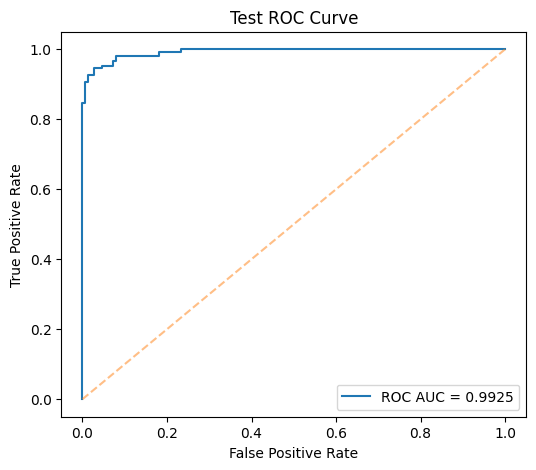

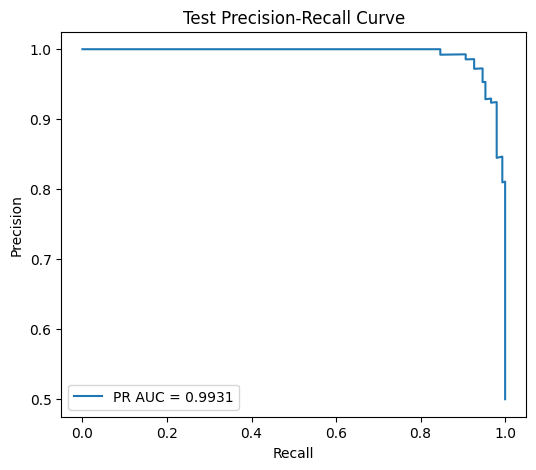

In [36]:
# 7) Plot ROC and Precision-Recall curves (test set) — display inline
def plot_roc_pr_inline(y_true, y_prob, title_prefix='Test'):
    # ROC
    try:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(6,5))
        plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.4f}')
        plt.plot([0,1],[0,1],'--', alpha=0.5)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{title_prefix} ROC Curve')
        plt.legend(loc='lower right')
        plt.show()
    except Exception as e:
        print("Could not plot ROC:", e)

    # PR
    try:
        precision, recall, _ = precision_recall_curve(y_true, y_prob)
        pr_auc = auc(recall, precision)
        plt.figure(figsize=(6,5))
        plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.4f}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'{title_prefix} Precision-Recall Curve')
        plt.legend(loc='lower left')
        plt.show()
    except Exception as e:
        print("Could not plot PR:", e)

# plot for test
if test_metrics['auc'] is not None:
    plot_roc_pr_inline(test_metrics['y_true'], test_metrics['y_prob'], title_prefix='Test')
else:
    print("Skipping ROC/PR plot: AUC could not be computed (maybe all labels same?).")

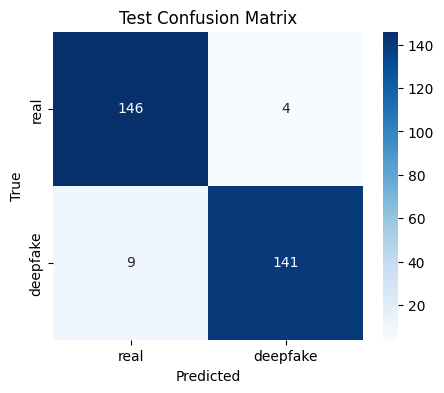


Evaluation summary:


,val_accuracy,val_auc,test_accuracy,test_auc
0,0.953333,0.994267,0.956667,0.992489



Evaluation complete. (All outputs displayed inline — no files were written.)


In [37]:
# 8) Confusion matrix heatmap (test) — display inline
def plot_confusion_inline(cm, labels=['real','deepfake'], title='Confusion Matrix'):
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

plot_confusion_inline(test_metrics['cm'], title='Test Confusion Matrix')

# 9) Summary (display only, do not save)
summary = {
    'val_accuracy': float(val_metrics['accuracy']),
    'val_auc': float(val_metrics['auc']) if val_metrics['auc'] is not None else None,
    'test_accuracy': float(test_metrics['accuracy']),
    'test_auc': float(test_metrics['auc']) if test_metrics['auc'] is not None else None,
}
print("\nEvaluation summary:")
display(pd.DataFrame([summary]))
print("\nEvaluation complete. (All outputs displayed inline — no files were written.)")

In [38]:
import json
merged_hist = {}
# merge histories if needed
if 'history' in globals():
    merged_hist.update(history.history)
if 'history_ft' in globals():
    for k,v in history_ft.history.items():
        merged_hist.setdefault(k, []).extend(v)
with open('/kaggle/working/training_history.json','w') as f:
    json.dump(merged_hist, f)


Note: 'accuracy' not found in history. Looking for 'auc' to plot as a proxy.
Using 'auc' and 'val_auc' for the accuracy-like plot.


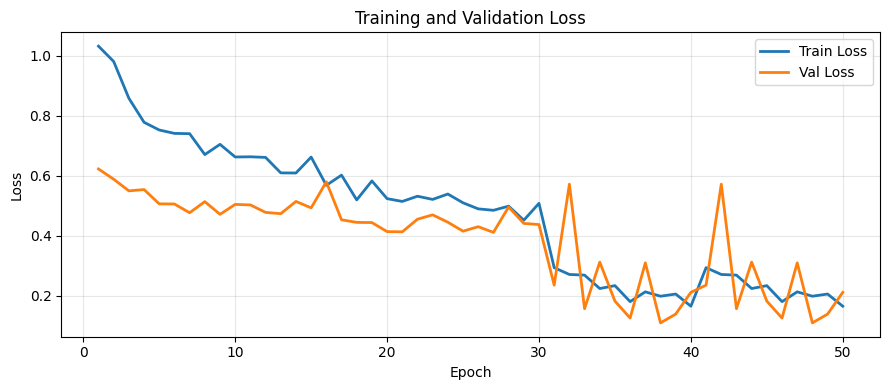

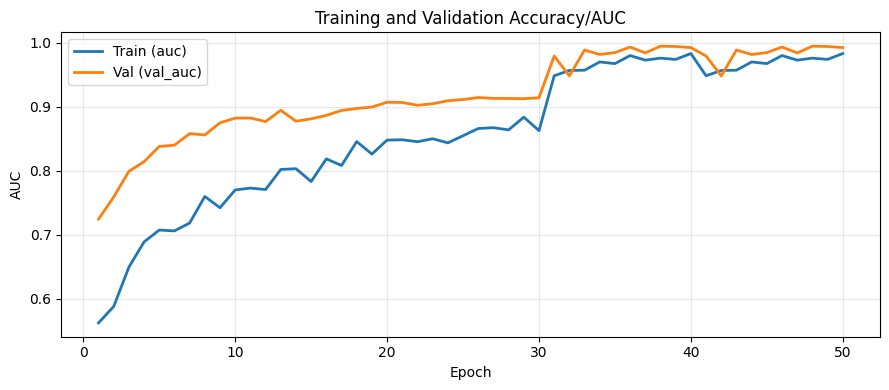


Summary (best validation metrics):


,best_val_loss_epoch,best_val_loss,best_val_acc_epoch,best_val_acc
0,38,0.109298,38,0.994289



Available history keys: ['auc', 'loss', 'val_auc', 'val_loss', 'learning_rate']


In [39]:
# Plot training & validation loss and accuracy (or AUC if accuracy not available).
import matplotlib.pyplot as plt
import numpy as np

# Collect available history objects
hist_list = []
if 'history' in globals() and history is not None:
    hist_list.append(history)
# history_ft may or may not exist
if 'history_ft' in globals() and history_ft is not None:
    hist_list.append(history_ft)

if len(hist_list) == 0:
    raise RuntimeError("No Keras history objects found in the notebook. Please run training first (history variable).")

# Merge histories: simply concatenate arrays in chronological order
def merge_histories(histobjs):
    merged = {}
    for h in histobjs:
        for k, v in h.history.items():
            merged.setdefault(k, []).extend(v)
    return merged

merged = merge_histories(hist_list)

# Helper to pick metric key names
def find_key(merged_dict, candidates):
    for c in candidates:
        if c in merged_dict:
            return c
    return None

# Loss keys
train_loss_key = find_key(merged, ['loss'])
val_loss_key = find_key(merged, ['val_loss'])

# Accuracy keys (try several names), fallback to AUC if no accuracy
train_acc_key = find_key(merged, ['accuracy', 'acc'])
val_acc_key = find_key(merged, ['val_accuracy', 'val_acc'])

if train_acc_key is None or val_acc_key is None:
    # Try AUC as surrogate
    print("Note: 'accuracy' not found in history. Looking for 'auc' to plot as a proxy.")
    train_acc_key = find_key(merged, ['auc'])
    val_acc_key = find_key(merged, ['val_auc'])
    if train_acc_key is None or val_acc_key is None:
        print("No 'accuracy' or 'auc' keys found. Accuracy/AUC plot will be skipped.")
        acc_available = False
    else:
        acc_available = True
        print(f"Using '{train_acc_key}' and '{val_acc_key}' for the accuracy-like plot.")
else:
    acc_available = True

# Basic checks
if train_loss_key is None or val_loss_key is None:
    raise RuntimeError("Could not find 'loss' and/or 'val_loss' in the training history.")

# Get arrays
train_loss = np.array(merged[train_loss_key])
val_loss = np.array(merged[val_loss_key])

epochs = np.arange(1, len(train_loss) + 1)

# Optional smoothing helper (simple moving average)
def smooth(x, w=3):
    if w <= 1:
        return x
    return np.convolve(x, np.ones(w)/w, mode='same')

SMOOTH = False   # set True to enable light smoothing
SMOOTH_WIN = 3

# Plot Loss
plt.figure(figsize=(9,4))
tl = smooth(train_loss, SMOOTH_WIN) if SMOOTH else train_loss
vl = smooth(val_loss, SMOOTH_WIN) if SMOOTH else val_loss
plt.plot(epochs, tl, label='Train Loss', linewidth=2)
plt.plot(epochs, vl, label='Val Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Accuracy/AUC if available
if acc_available and train_acc_key in merged and val_acc_key in merged:
    train_acc = np.array(merged[train_acc_key])
    val_acc = np.array(merged[val_acc_key])
    ea = np.arange(1, len(train_acc) + 1)
    plt.figure(figsize=(9,4))
    ta = smooth(train_acc, SMOOTH_WIN) if SMOOTH else train_acc
    va = smooth(val_acc, SMOOTH_WIN) if SMOOTH else val_acc
    plt.plot(ea, ta, label=f'Train ({train_acc_key})', linewidth=2)
    plt.plot(ea, va, label=f'Val ({val_acc_key})', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel(train_acc_key if 'acc' in train_acc_key else 'AUC')
    plt.title('Training and Validation Accuracy/AUC')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Skipping accuracy/AUC plot because required keys are not available in the merged history.")

# Show a short tabular summary of best metrics
def best_metric(arr):
    arr = np.array(arr)
    idx = int(np.nanargmax(arr))
    return idx+1, float(arr[idx])

summary = {}
# best val loss (min)
best_epoch_loss = int(np.argmin(val_loss)) + 1
summary['best_val_loss_epoch'] = best_epoch_loss
summary['best_val_loss'] = float(val_loss[best_epoch_loss-1])
if acc_available and train_acc_key in merged and val_acc_key in merged:
    be_idx, be_val = best_metric(merged[val_acc_key])
    summary['best_val_acc_epoch'] = be_idx
    summary['best_val_acc'] = be_val

import pandas as pd
print("\nSummary (best validation metrics):")
display(pd.DataFrame([summary]))

# If you want the raw merged keys available for inspection
print("\nAvailable history keys:", list(merged.keys()))


Counts -> TP: 141, TN: 146, FP: 4, FN: 9


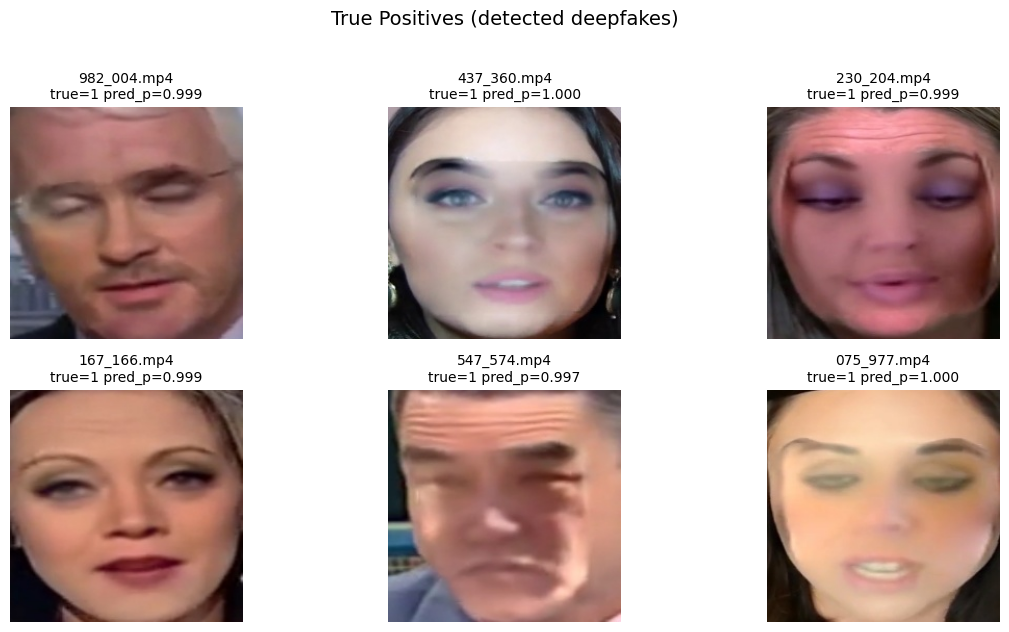

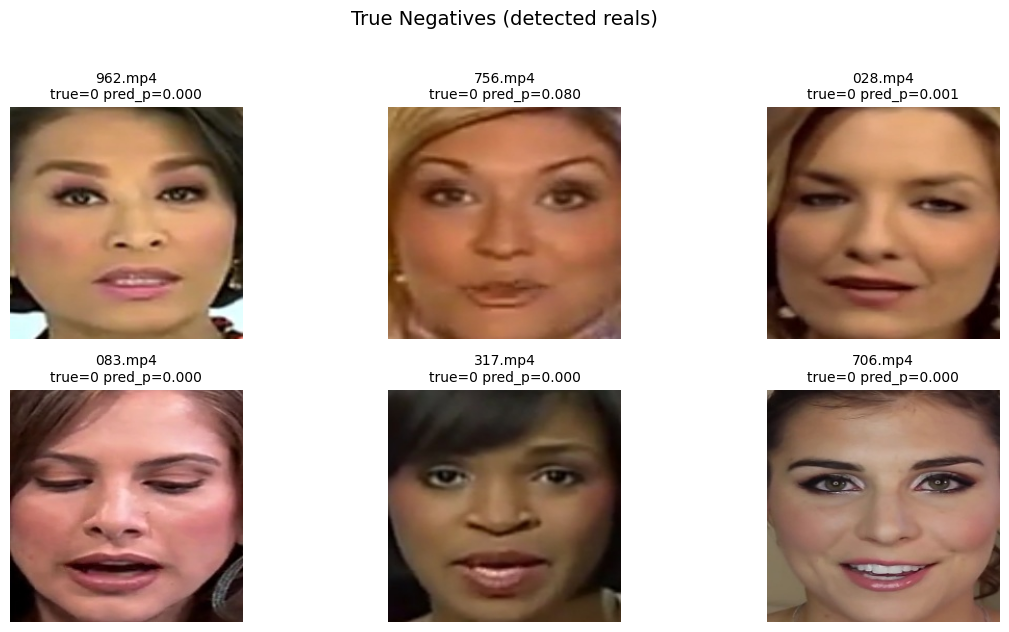

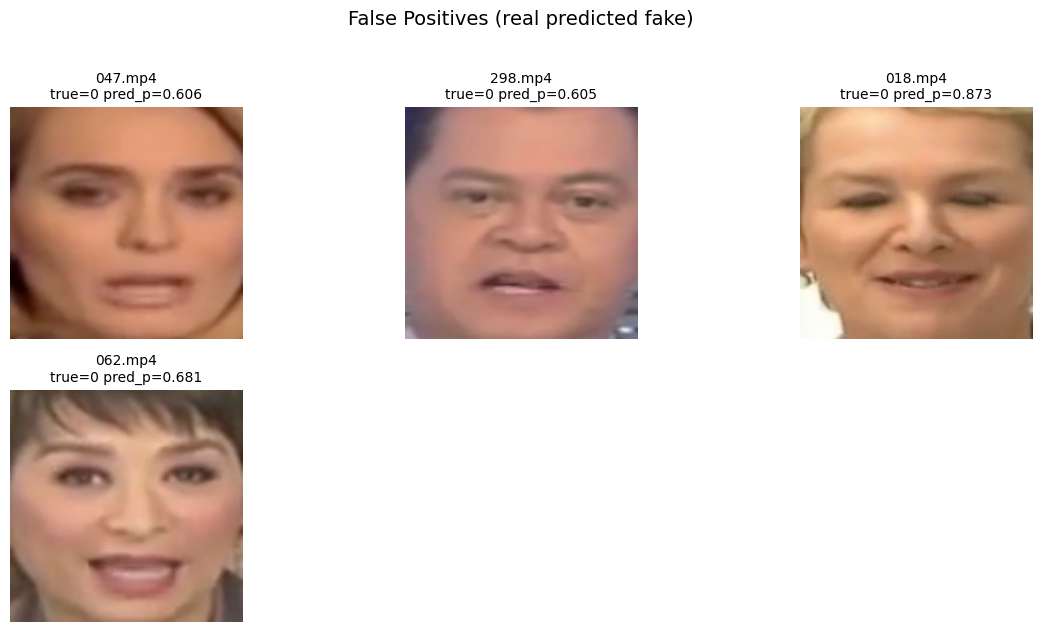

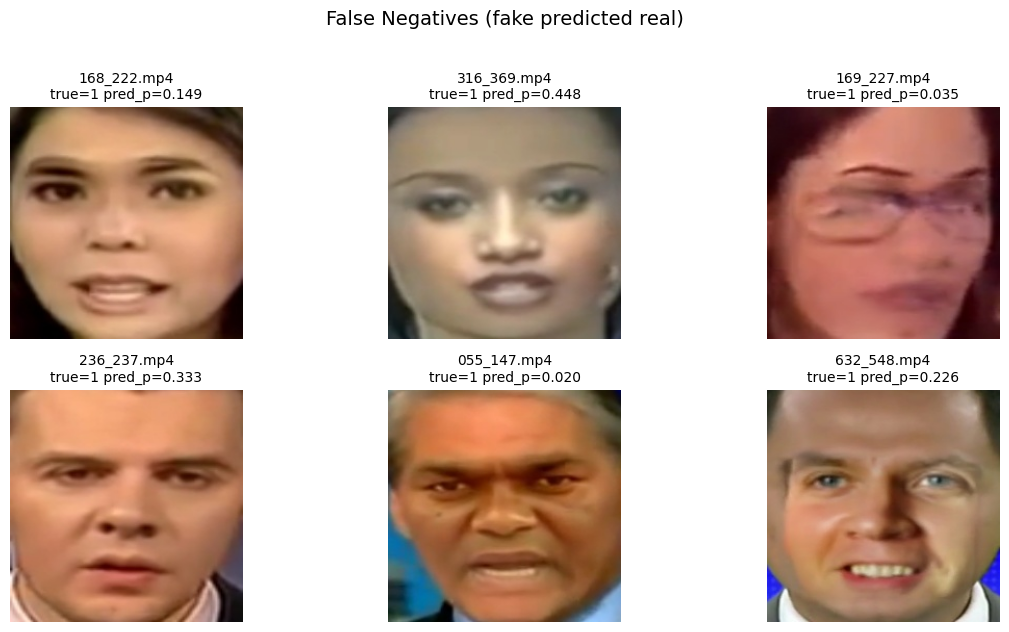


Sample video ids per category:
TP: ['982_004.mp4', '437_360.mp4', '230_204.mp4', '167_166.mp4', '547_574.mp4', '075_977.mp4']
TN: ['962.mp4', '756.mp4', '028.mp4', '083.mp4', '317.mp4', '706.mp4']
FP: ['298.mp4', '062.mp4', '047.mp4', '018.mp4']
FN: ['168_222.mp4', '316_369.mp4', '169_227.mp4', '236_237.mp4', '055_147.mp4', '632_548.mp4']


In [40]:
# Display representative frames for TP/TN/FP/FN examples
import os, random, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Config
N_PER_CAT = 6   # number of examples to show per category
SEQ_LEN = globals().get('SEQ_LEN', 16)  # use existing SEQ_LEN if available
IMG_SIZE = globals().get('IMG_SIZE', 224)
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Try to get prediction and test dataframes (robust)
pred_df = None
if 'test_pred_df' in globals():
    pred_df = test_pred_df.copy()
else:
    # try common csv locations
    for p in ['/kaggle/working/test_video_predictions.csv', '/kaggle/working/test_predictions.csv', '/kaggle/working/test_pred.csv']:
        if os.path.exists(p):
            pred_df = pd.read_csv(p)
            print("Loaded predictions from", p)
            break

if pred_df is None:
    raise RuntimeError("Prediction DataFrame not found. Ensure `test_pred_df` exists or CSV was saved to /kaggle/working/ with a recognized name.")

# Ensure pred_df has columns: video_id, label_true, pred_prob, pred_bin
for col in ['video_id','label_true','pred_prob']:
    if col not in pred_df.columns:
        raise RuntimeError(f"Prediction CSV missing required column: {col}")

# If pred_bin missing, create it using threshold 0.5
if 'pred_bin' not in pred_df.columns:
    pred_df['pred_bin'] = (pred_df['pred_prob'] >= 0.5).astype(int)

# Load test_df that contains frame_folder mapping
test_df_local = None
if 'test_df' in globals():
    test_df_local = test_df.copy()
else:
    # try to load the earlier saved CSVs
    for p in ['/kaggle/working/test.csv', '/kaggle/working/csvs/test.csv', '/kaggle/working/test_video_predictions.csv']:
        if os.path.exists(p) and p.endswith('test.csv'):
            test_df_local = pd.read_csv(p)
            print("Loaded test split CSV from", p)
            break

# If we still don't have test_df mapping, try to infer frame_folder using possible structure
if test_df_local is None:
    # attempt to build minimal mapping using video_id and dataset root paths
    possible_roots = [
        '/kaggle/input/dataset/Extracted_Faces/Extracted_Faces/real',
        '/kaggle/input/dataset/Extracted_Faces/Extracted_Faces/deepfake',
        '/kaggle/working'
    ]
    # try to find folder for each video id by searching top-level working directories (expensive)
    rows = []
    for _, r in pred_df.iterrows():
        vid = str(r['video_id'])
        found = None
        for root in possible_roots:
            candidate = os.path.join(root, vid)
            if os.path.isdir(candidate):
                found = candidate
                break
        if found:
            rows.append({'video_id': vid, 'frame_folder': found, 'label': 'deepfake' if int(r['label_true'])==1 else 'real'})
    if len(rows) == 0:
        raise RuntimeError("Could not locate `test_df` or frame folders for predictions. Please ensure `test_df` (with frame_folder column) exists or that dataset folders are reachable.")
    test_df_local = pd.DataFrame(rows)
    print("Built fallback test_df_local with", len(rows), "entries.")

# Merge predictions with test_df_local on video_id to get frame_folder
merged = pred_df.merge(test_df_local[['video_id','frame_folder']], on='video_id', how='left')
if merged['frame_folder'].isna().any():
    missing = merged[merged['frame_folder'].isna()]
    print("Warning: some videos have missing frame_folder mapping (showing up to 5):")
    display(missing.head())
    # drop missing
    merged = merged.dropna(subset=['frame_folder']).reset_index(drop=True)

# Define categories
# true positive: label_true==1 & pred_bin==1
# true negative: label_true==0 & pred_bin==0
# false positive: label_true==0 & pred_bin==1
# false negative: label_true==1 & pred_bin==0
tp = merged[(merged['label_true']==1) & (merged['pred_bin']==1)].copy()
tn = merged[(merged['label_true']==0) & (merged['pred_bin']==0)].copy()
fp = merged[(merged['label_true']==0) & (merged['pred_bin']==1)].copy()
fn = merged[(merged['label_true']==1) & (merged['pred_bin']==0)].copy()

print(f"Counts -> TP: {len(tp)}, TN: {len(tn)}, FP: {len(fp)}, FN: {len(fn)}")

# Helper: use existing sample_frames_from_folder_py if present, otherwise provide a fallback
if 'sample_frames_from_folder_py' in globals():
    sampler = sample_frames_from_folder_py
else:
    import cv2
    def fallback_sample_frames_from_folder_py(frame_folder, t=SEQ_LEN, mode='uniform'):
        imgs = sorted([os.path.join(frame_folder, f) for f in os.listdir(frame_folder) if f.lower().endswith(('.jpg','.jpeg','.png'))])
        N = len(imgs)
        if N == 0:
            return np.zeros((t, IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)
        if N <= t:
            idx = list(range(N)) + [N-1]*(t-N)
        else:
            if mode == 'uniform':
                idx = np.linspace(0, N-1, t).astype(int).tolist()
            else:
                start = random.randint(0, max(0, N-t))
                idx = list(range(start, start+t))
        out = []
        for i in idx:
            im = cv2.imread(imgs[i])
            if im is None:
                im = np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)
            else:
                im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
                im = cv2.resize(im, (IMG_SIZE, IMG_SIZE))
            out.append(im.astype(np.uint8))
        return np.stack(out, axis=0)
    sampler = fallback_sample_frames_from_folder_py
    print("Using fallback sampler (no preprocess inversion). Images will be displayed as read.")

# Function to de-process VGG-preprocessed frames (if frames were preprocessed earlier)
def deprocess_vgg_frame(img):
    """
    img: float32 array in VGG preprocessed format (BGR - mean). Reverse to RGB uint8.
    If values look strange, we'll attempt both deprocess and naive clipping.
    """
    try:
        # mean in BGR used by Keras VGG (caffe): [103.939, 116.779, 123.68]
        mean = np.array([103.939, 116.779, 123.68], dtype=np.float32)
        # add mean back (img currently likely BGR-mean)
        x = img + mean
        # convert BGR -> RGB
        x = x[..., ::-1]
        x = np.clip(x, 0, 255).astype(np.uint8)
        return x
    except Exception:
        # fallback: rescale
        x = img - img.min()
        if x.max() > 0:
            x = x / x.max() * 255.0
        return x.astype(np.uint8)

# Decide whether sampled frames are preprocessed (float with negative values) or raw uint8
def is_preprocessed_array(arr):
    return arr.dtype in [np.float32, np.float64] and (arr.min() < -1 or arr.max() > 1)  # heuristic

# Function to get a representative RGB image from a folder
def get_repr_frame(folder, seq_len=SEQ_LEN, mode='uniform'):
    seq = sampler(folder, t=seq_len, mode=mode)
    mid = seq_len // 2
    frame = seq[mid]
    if is_preprocessed_array(frame):
        try:
            frame_rgb = deprocess_vgg_frame(frame)
        except:
            # fallback normalization
            mn = frame.min(); mx = frame.max()
            if mx - mn > 0:
                frame_rgb = ((frame - mn) / (mx - mn) * 255).astype(np.uint8)
            else:
                frame_rgb = np.zeros_like(frame, dtype=np.uint8)
    else:
        frame_rgb = frame.astype(np.uint8)
    return frame_rgb

# Small helper to display a list of videos in a grid
def show_examples(df_subset, title, n=N_PER_CAT):
    if len(df_subset) == 0:
        print(f"No examples for {title}")
        return
    n_show = min(n, len(df_subset))
    chosen = df_subset.sample(n_show, random_state=RANDOM_SEED) if len(df_subset)>n_show else df_subset
    fig_cols = min(3, n_show)
    fig_rows = math.ceil(n_show / fig_cols)
    plt.figure(figsize=(fig_cols*4, fig_rows*3.2))
    for i, (_, row) in enumerate(chosen.iterrows()):
        folder = row['frame_folder']
        vid = row['video_id']
        prob = float(row['pred_prob'])
        true = int(row['label_true'])
        try:
            img = get_repr_frame(folder, seq_len=SEQ_LEN, mode='uniform')
        except Exception as e:
            print(f"Could not load frames for {vid} from {folder}: {e}")
            img = np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)
        ax = plt.subplot(fig_rows, fig_cols, i+1)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"{vid}\ntrue={true} pred_p={prob:.3f}", fontsize=10)
    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Show example grids
show_examples(tp, "True Positives (detected deepfakes)")
show_examples(tn, "True Negatives (detected reals)")
show_examples(fp, "False Positives (real predicted fake)")
show_examples(fn, "False Negatives (fake predicted real)")

# If you want, you can also list the video_ids of each category:
print("\nSample video ids per category:")
def sample_ids(df, n=5):
    return df['video_id'].sample(min(len(df), n), random_state=RANDOM_SEED).tolist() if len(df)>0 else []
print("TP:", sample_ids(tp, 6))
print("TN:", sample_ids(tn, 6))
print("FP:", sample_ids(fp, 6))
print("FN:", sample_ids(fn, 6))


In [1]:
import json
meta = {
    "seed": int(globals().get('RANDOM_SEED', 42)),
    "seq_len": int(globals().get('SEQ_LEN', 16)),
    "img_size": int(globals().get('IMG_SIZE', 224)),
    "batch_size": int(globals().get('BATCH_SIZE', 8)),
    "backbone": "VGG16",
    "notes": "Pair-aware 70/15/15 split; frames extracted at 10 fps; faces resized to 224x224"
}
with open('metadata.json','w') as f:
    json.dump(meta, f, indent=2)
print("Saved metadata.json")


Saved metadata.json
